# Probability and Information Theory

## Steps

1. Understand the problem and the mathematical model and generate data
2. Load the (generated) data and get an overview
3. Try to fit parametric probability distributions
4. Joint  and conditional probabilities, chain rule and Bayes' Theorem
5. Self-entropy of an event and entropy of a distribution

## Understand the problem and the mathematical model and generate data

From [1] we learned the following simplified model for simulating and understanding the spreading of diseases. 

<img src="img/epidemic_process.png" alt="Epidemic process" style="width: 400px;"/>

A fraction of $\beta$ of the susceptible individuals $S$ gets infected each unit of time, say each day, depending on the number of infected $I$. A fraction $\mu$ of the infected recover. A simple generalization is a third parameter $\nu$ and the assumption that only $\nu\mu$ individuals recover, while ${1-\nu}\mu$ individuals die.

This leads to the following system of ordinary differencial equations (ODEs):

\begin{align}
\frac{\delta S}{\delta t} & = -\beta S(t)I(t)\\
\frac{\delta I}{\delta t} & = \beta S(t)I(t) -\mu I(t)\\
\frac{\delta R}{\delta t} & = \nu\mu I(t)\\
\frac{\delta D}{\delta t} & = (1-\nu)\mu I(t)
\end{align}

Given starting values of $S(0)=99, I(0)=1, R(0)=D(0)=0$ and parameter values for $\beta=0.05\%, \mu=1.75\%, \nu=99\%$, we can simulate this system of ODEs.

In `Matlab`, we use the ordinary differencial equation solver `ode45`.

In [2]:
%%file virusSpreading.m
function res = virusSpreading(t, y, beta, mu, nu)
    S=y(1);
    I=y(2);
    R=y(3);
    D=y(4);
    
    res(1,1)=-beta*S*I;
    res(2,1)=beta*S*I-mu*I;
    res(3,1)=nu*mu*I;
    res(4,1)=(1-nu)*mu*I;
end

Created file '/Users/wlomsi/Documents/ProjekteUni/Vorlesungen/ML 4DV660+4DV661+4DV652/Public ML Notebooks/virusSpreading.m'.


In [3]:
%%file simVirusSpreading.m
function res = simVirusSpreading(beta, verbose)
    S0 =99;
    I0 =1;
    R0 = 0;
    D0 = 0;
    y0 = [S0, I0, R0, D0]';
    t_span = [0 500];
    mu = 0.0175;
    nu = 0.99;
    [tSol, ySol] = ode45(@(t,y) virusSpreading(t, y, beta, mu, nu), t_span, y0);
    if verbose
        plot(tSol, ySol);
        legend("Susceptible","Infected","Recovered","Dead");
    end
    res = [tSol, ySol];
end

Created file '/Users/wlomsi/Documents/ProjekteUni/Vorlesungen/ML 4DV660+4DV661+4DV652/Public ML Notebooks/simVirusSpreading.m'.


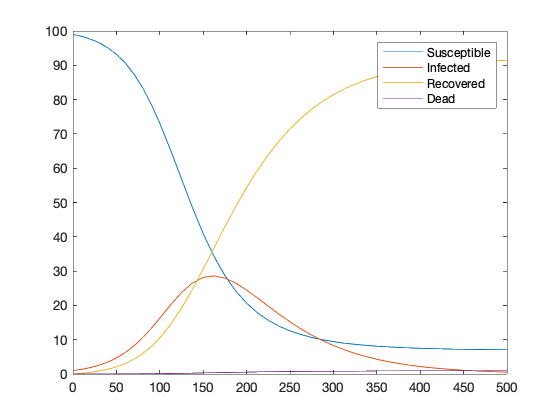

In [4]:
format compact
beta = 0.0005; %0.05%
simVirusSpreading(beta, true);

Note that the development highly depends on the parameter $\beta$. So, if all behave well, the infection risk drops and the infection spreading slows down. Inversely, if we misbehave and increase the risk of infection, the infection spreads faster. Here simulations with $\beta = 0.03\%$ and $\beta = 0.07\%$, respectively.

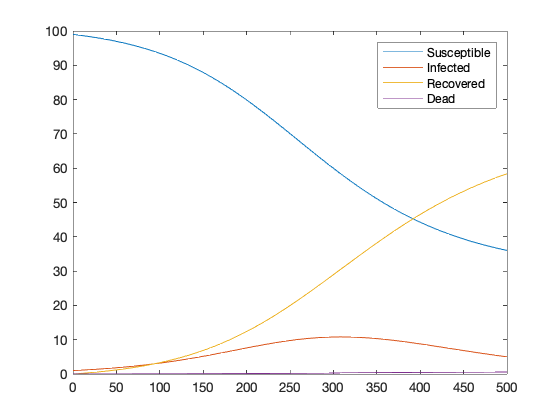

In [5]:
beta = 0.0003;
simVirusSpreading(beta, true);

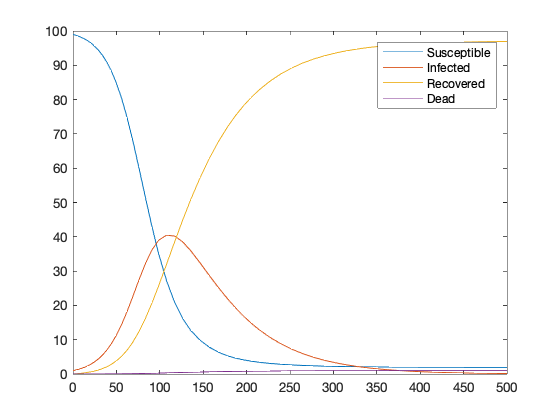

In [6]:
beta = 0.0007;
simVirusSpreading(beta, true);

Of course, the exact parameters values for $\beta, \mu, \nu$ are not known but can only be approximated from observations. The ODE model is an abstraction of the real process, which depends on deterministic but unknown variables and randomness. Therefore, it makes sense to understand disease spreading as a **random process.**

We will generate some observations from this process from different countries and then forget about the process and only work with the observations.

Therefore, we assume that $\beta$ distributes normally around a mean of $\bar \beta = 0.05\%$ with a standard deviation of $\sigma = 0.01\%$. We generate the data for $50$ countries. However, we are only "observing" $8$ new features.

1. The numbers $N_{50}, N_{150}, N_{300}$ of infected after $50, 150, 300$ days, resp. 
2. The corresponding numbers of new infections on that day $D_{50}, D_{150}, D_{300}$.
3. The time $T_{peak}$ to peak infection.
4. The total number of casulties $X_{500}$ after $500$ days.

In [7]:
countries = 125;
verbose = false;
export_raw_data = true;
if verbose
    countries=1;
end
if export_raw_data
    raw_features = zeros(4*countries, 501);
    raw_features(1,:) = 1:501;
end
features = zeros(countries,8);
rng('default')  % For reproducibility
betas = normrnd(0.0005,0.0001,[1,countries]);
for i=1:countries
    res = simVirusSpreading(betas(i), false);
    times = res(:,1);
    % Add randomness to the observations
    rand_res = zeros(size(res,1),5);
    rand_res(:,1) = times;
    for j=2:5
        rand_res(:,j) = arrayfun(@(x) normrnd(0,0.025*x)+x, res(:,j));
    end
    if verbose
        fprintf("Beta = %.3f%%\n",betas(1)*100);
        plot(times,[res(:,2) rand_res(:,2), res(:,3) rand_res(:,3),res(:,4) rand_res(:,4),res(:,5) rand_res(:,5)]);        
    end
    if export_raw_data
        days = [0:500];
        for var = 2:5
            F = griddedInterpolant(rand_res(:,1),rand_res(:,var));
            raw_features((i-1)*4+var,:)=F(days);
        end
    end
    ti = times(times<=50);
    n_50 = rand_res(length(ti),3);
    d_50 = rand_res(length(ti),3) - rand_res(length(ti)-1,3);
    ti = times(times<=150);
    n_150 = rand_res(length(ti),3);
    d_150 = rand_res(length(ti),3) - rand_res(length(ti)-1,3);
    ti = times(times<=300);
    n_300 = rand_res(length(ti),3);
    d_300 = rand_res(length(ti),3) - rand_res(length(ti)-1,3);
    [M,ii] = max(rand_res(:,3));
    t_peak = times(ii);
    if verbose
        fprintf("n_50=%.4f, n_150=%.4f, n_300=%.4f\nd_50=%.4f, d_150=%.4f, d_300=%.4f\nt_peak=%.4f\nx_500=%.4f\n",n_50, n_150, n_300, d_50, d_150, d_300, t_peak, rand_res(end,5) );
    end
    features(i,:)=[n_50, n_150, n_300, d_50, d_150, d_300, t_peak, rand_res(end,5)];
end
writematrix(features,'../2020 DL data/epidemic_process.csv');
if export_raw_data
    writematrix(raw_features,'../2020 DL data/epidemic_process_raw_data.csv');
end

## Load the (generated) data and get an overview

This is your starting point. Load the observation data.

In [8]:
features = csvread('../2020 DL data/epidemic_process.csv');

Plot the emperical **cumulative probability distributions** (CDFs) of the **random variables** (features).

stats = 
  struct with fields:

       min: 1.1742
       max: 17.8623
      mean: 5.0055
    median: 4.2267
       std: 2.8459



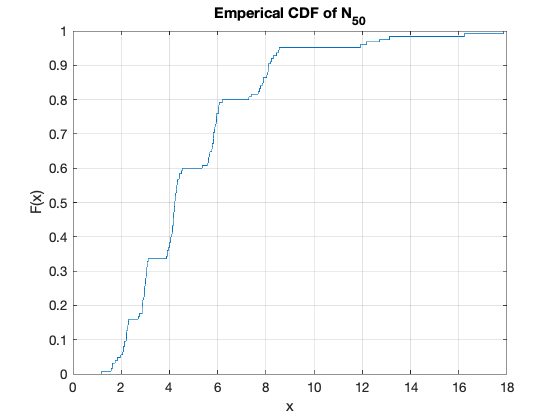

In [9]:
[h,stats] = cdfplot(features(:,1));
title("Emperical CDF of N_{50}")
stats

stats = 
  struct with fields:

       min: 1.3896
       max: 35.8727
      mean: 24.8589
    median: 27.8081
       std: 9.3066



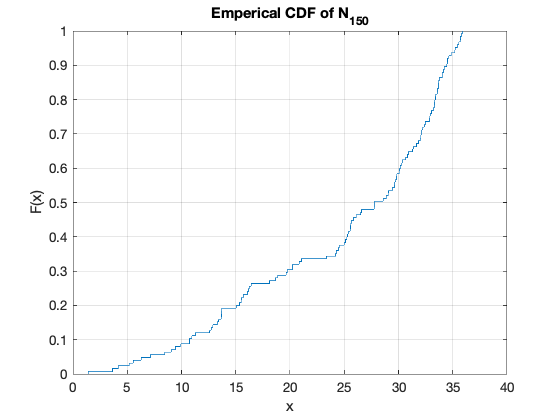

In [10]:
[h,stats] = cdfplot(features(:,2));
title("Emperical CDF of N_{150}")
stats

stats = 
  struct with fields:

       min: 1.7930
       max: 15.2188
      mean: 8.9159
    median: 8.5051
       std: 3.6790



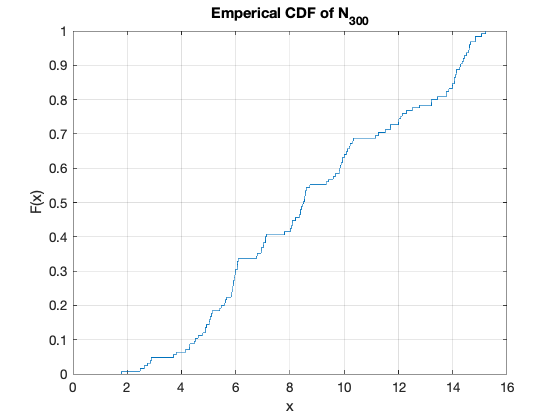

In [11]:
[h,stats] = cdfplot(features(:,3));
title("Emperical CDF of N_{300}")
stats

stats = 
  struct with fields:

       min: -0.0415
       max: 4.1011
      mean: 1.0087
    median: 0.8765
       std: 0.6805



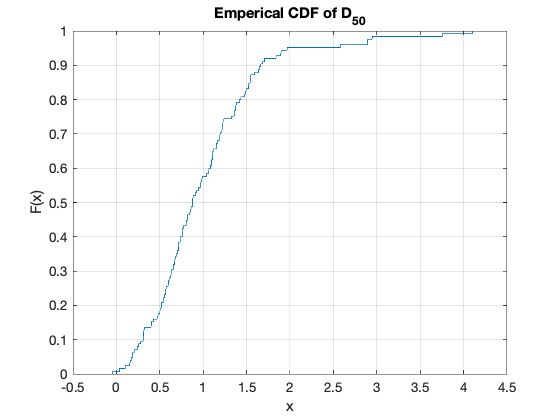

In [12]:
[h,stats] = cdfplot(features(:,4));
title("Emperical CDF of D_{50}")
stats

stats = 
  struct with fields:

       min: -5.7154
       max: 4.2410
      mean: 0.7285
    median: 1.3688
       std: 2.0868



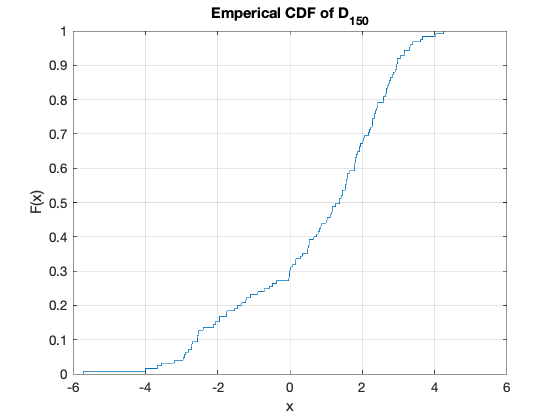

In [13]:
[h,stats] = cdfplot(features(:,5));
title("Emperical CDF of D_{150}")
stats

stats = 
  struct with fields:

       min: -2.2931
       max: 0.6609
      mean: -1.1907
    median: -1.2389
       std: 0.5242



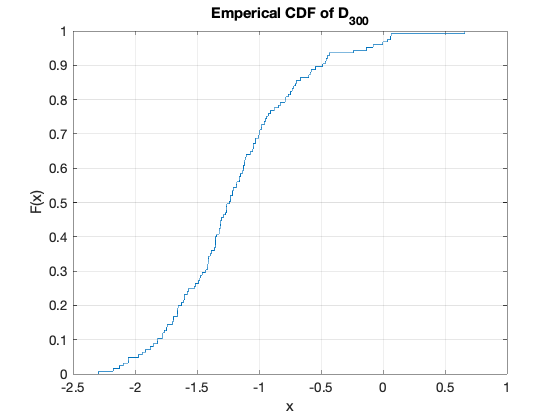

In [14]:
[h,stats] = cdfplot(features(:,6));
title("Emperical CDF of D_{300}")
stats

stats = 
  struct with fields:

       min: 86.1405
       max: 420.3053
      mean: 170.0487
    median: 157.5149
       std: 53.7913



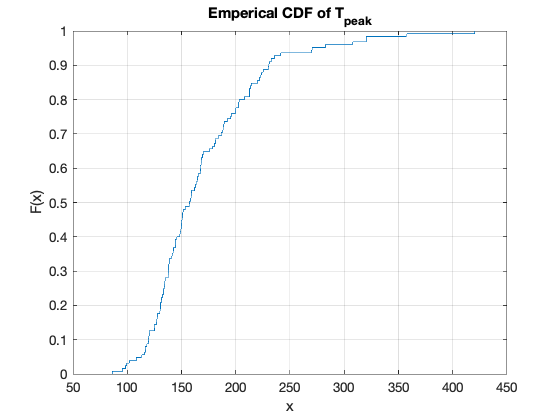

In [15]:
[h,stats] = cdfplot(features(:,7));
title("Emperical CDF of T_{peak}")
stats

stats = 
  struct with fields:

       min: 0.1423
       max: 1.0134
      mean: 0.8930
    median: 0.9244
       std: 0.1143



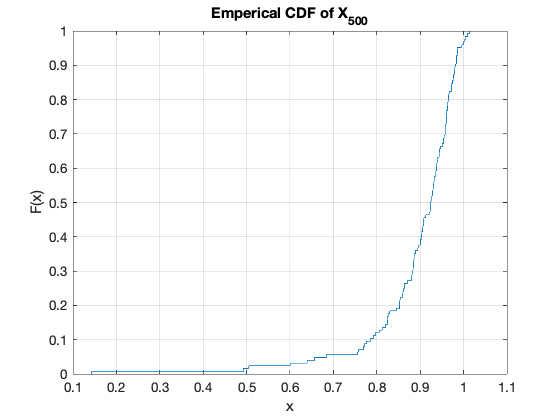

In [17]:
[h,stats] = cdfplot(features(:,8));
title("Emperical CDF of X_{500}")
stats

Recall, the sample `mean` value is an approximation of the expected value, or **expectation** of the random variable. The sample **variance** is the square of the sample standard deviation `std`. Recall the bias of sample variance and expected population variance that needs to be corrected by dividing by $n-1$ instead $n$ when estimating the variance of the population from the sample.

Check the correlation between the features.

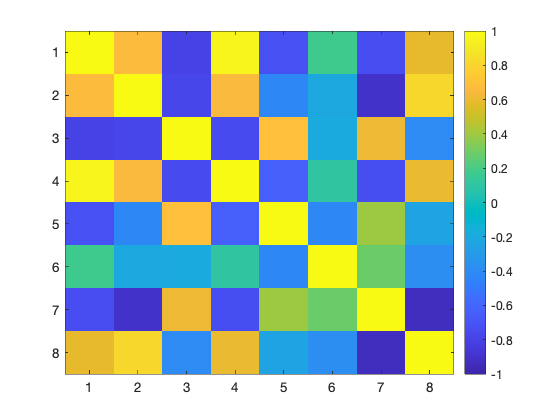

In [19]:
rho = corrcoef(features);
imagesc(rho, [-1 1]);
colorbar;

Recall, the (sample) correlation of two (samples of) random variables $X$ and $Y$ their (sample) **covariance** normalized (divided) by the product of their (sample) standard deviation.

*Discuss your findings. Your answer goes here.*

## Try to fit parametric probability distributions

We go through a set of common probability distributions and try to fit any of them  to the data. We use the Chi-square and the Kolmogorov-Smirnov tests to check the goodness of fit. 

*Note that fitting and testing using the same data is actually not quite correct. We should use cross-validation.*

In [20]:
%%file distribution_fitting.m
function pd = distribution_fitting(feature)
    distnames =["Normal","Poisson", "Exponential", "Gamma", "ExtremeValue", "Kernel"];
    values_must_be_positive =["Poisson", "Exponential", "Gamma"];
    x=feature.';
    x_values = linspace(min(x),max(x));
    for dn=distnames
        if min(x)<0 & ~isempty(find(strcmp(dn, values_must_be_positive)))
          continue;
        end
        distname = char(dn);
        pd = fitdist(x.',distname);
        res1=kstest(x, 'CDF', pd); 
        res2=chi2gof(x, 'CDF', pd);
        if (~res1 && ~res2)
            fprintf('%s with 5%% significance level\r',distname);
            cdfplot(x)
            hold on
            plot(x_values,cdf(pd,x_values),'r-')
            plot(x_values,pdf(pd,x_values),'g-')
            legend('Empirical CDF',[distname ' CDF'],[distname ' PDF'],'Location','best');
            title(['Empirical CDF and ', [distname ' CDF/PDF']]);
            hold off 
            return;
        else 
            fprintf('Not %s with 5%% significance level\n',distname);
        end
    end
end

Created file '/Users/wlomsi/Documents/ProjekteUni/Vorlesungen/ML 4DV660+4DV661+4DV652/Public ML Notebooks/distribution_fitting.m'.


In [21]:
pd_n_50 = distribution_fitting(features(:,1))

Not Normal with 5% significance level
Not Poisson with 5% significance level
Not Exponential with 5% significance level
Not Gamma with 5% significance level
Not ExtremeValue with 5% significance level
Not Kernel with 5% significance level
pd_n_50 = 
  KernelDistribution

    Kernel = normal
    Bandwidth = 0.924168
    Support = unbounded




Not Normal with 5% significance level
Not Poisson with 5% significance level
Not Exponential with 5% significance level
Not Gamma with 5% significance level
Not ExtremeValue with 5% significance level
pd_n_150 = 
  KernelDistribution

    Kernel = normal
    Bandwidth = 3.52322
    Support = unbounded




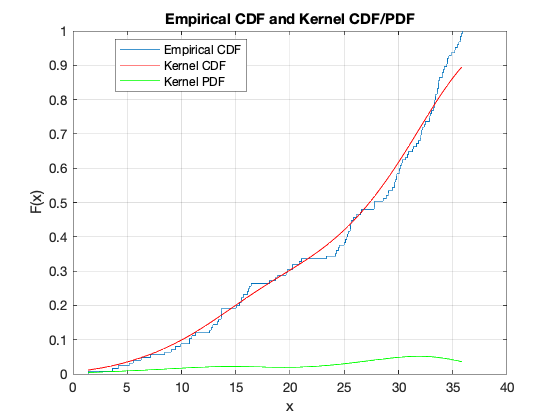

In [22]:
pd_n_150 = distribution_fitting(features(:,2))

Not Normal with 5% significance level
Not Poisson with 5% significance level
Not Exponential with 5% significance level
pd_n_300 = 
  GammaDistribution

  Gamma distribution
    a = 5.25681   [4.13323, 6.68581]
    b = 1.69608   [1.31783, 2.18288]




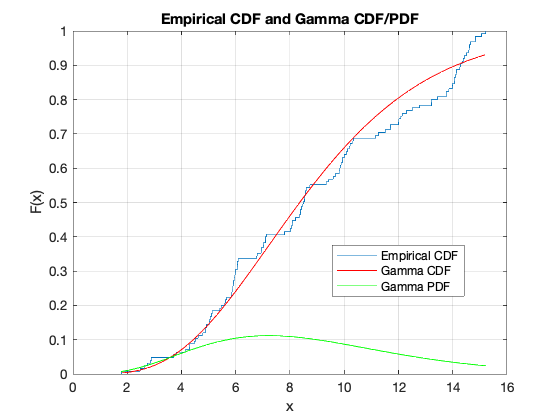

In [23]:
pd_n_300 = distribution_fitting(features(:,3))

Not Normal with 5% significance level
Not ExtremeValue with 5% significance level
pd_d_50 = 
  KernelDistribution

    Kernel = normal
    Bandwidth = 0.2031
    Support = unbounded




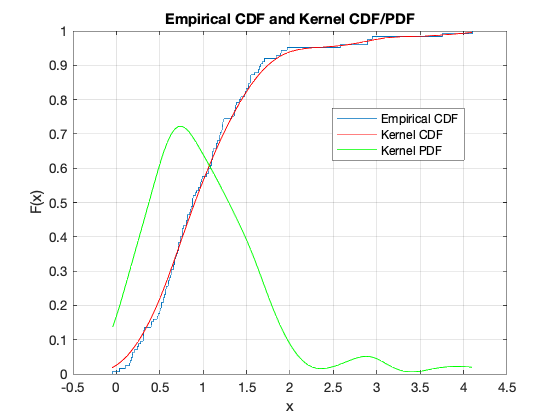

In [24]:
pd_d_50 = distribution_fitting(features(:,4))

Not Normal with 5% significance level
Not ExtremeValue with 5% significance level
pd_d_150 = 
  KernelDistribution

    Kernel = normal
    Bandwidth = 0.768931
    Support = unbounded




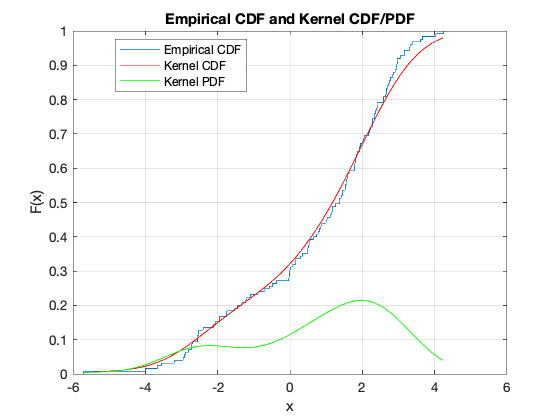

In [25]:
pd_d_150 = distribution_fitting(features(:,5))

pd_d_300 = 
  NormalDistribution

  Normal distribution
       mu = -1.19065   [-1.28345, -1.09786]
    sigma = 0.524156   [0.466248, 0.598617]




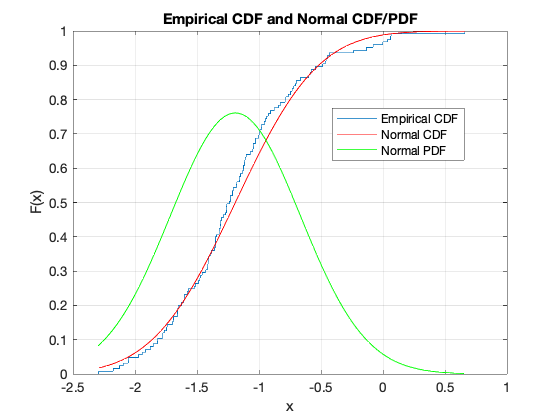

In [26]:
pd_d_300 = distribution_fitting(features(:,6))

Not Normal with 5% significance level
Not Poisson with 5% significance level
Not Exponential with 5% significance level
Not Gamma with 5% significance level
Not ExtremeValue with 5% significance level
pd_t_peak = 
  KernelDistribution

    Kernel = normal
    Bandwidth = 16.1238
    Support = unbounded




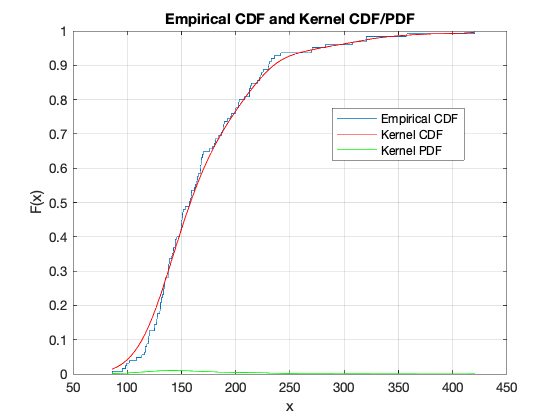

In [27]:
pd_t_peak = distribution_fitting(features(:,7))

Not Normal with 5% significance level
Not Poisson with 5% significance level
Not Exponential with 5% significance level
Not Gamma with 5% significance level
pd_x_500 = 
  ExtremeValueDistribution

  Extreme Value distribution
       mu =  0.934172   [0.922844, 0.945501]
    sigma = 0.0621877   [0.0536918, 0.0720279]




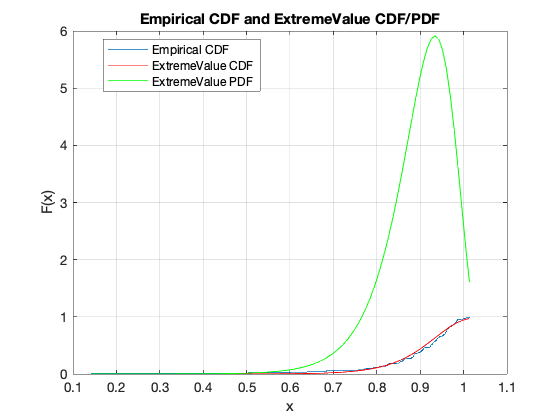

In [28]:
pd_x_500 = distribution_fitting(features(:,8))

*Describe the fitted distributions. Your answer goes here.*

## Joint  and conditional probabilities, chain rule and Bayes' Theorem

Lets calculate the probability of having a mild start and a disastrous end of the epidemia. We translate that to the **joint probability** that no more than $4\%$ are infected after $50$ days, i.e., $N_{50}\leq 4\%$ and more than $0.95\%$ die in the end, i.e., $X_{500}>0.95\%$.

In [31]:
n_50 = features(:,1);
x_500 = features(:,8);
positive_cases = length(intersect(find(n_50<=4),find(x_500>0.95)))
all_cases = length(features)
P = positive_cases/all_cases

positive_cases =
     1
all_cases =
   125
P =
    0.0080



So $P(N_{50}\leq 4\%, X_{500}>0.95\%) \approx 0.008$.

We check the product of the two probabilities $P(N_{50}\leq 4\%)P(X_{500}>0.95\%)$:

In [32]:
P2 = length(find(n_50<=4))/all_cases * length(find(x_500>0.95))/all_cases

P2 =
    0.1263



We are not surprised that the result is different from the joint probability as the random variables $N_{50}$ and $X_{500}$ not independent (double-check the results from the correlation analysis).  

What is the **conditional probability** of more than $0.95\%$ die in the end given that we know that no more $4\%$ are infected after $50$ days.

In [33]:
mild_start_cases = length(find(n_50<=4));
P_AB = positive_cases/mild_start_cases

P_AB =
    0.0213



So $P(X_{500}>0.95\%|N_{50}\leq 4\%) \approx 0.0213$.

The product or **chain rule** of probability states that

\begin{align}
P(A,B) &= P(A|B)P(B)\\
P(X_{500}>0.95\%,N_{50}\leq 4\%) &= P(X_{500}>0.95\%|N_{50}\leq 4\%)P(N_{50}\leq 4\%)
\end{align}

And we don't get disappointed:

In [34]:
P_B = mild_start_cases/all_cases;
P = P_AB*P_B

P =
    0.0080



Let us numerically confirm **Bayes' Theorem** for this case. We'd expect that  

\begin{align}
P(A|B) &= \frac{P(B|A)P(A)}{P(B)}\\
P(X_{500}>0.95\%|N_{50}\leq 4\%) &= \frac{P(N_{50}\leq 4\%|X_{500}>0.95\%)P(X_{500}>0.95\%)}{P(N_{50}\leq 4\%)}
\end{align}

And we don't get disappointed:

In [35]:
disaster_cases = length(find(x_500>0.95));
P_A = disaster_cases/all_cases;
P_BA = positive_cases/disaster_cases;
P_AB = P_BA*P_A/P_B

P_AB =
    0.0213



So far, we have looked at the joint (sample) probability of $P(N_{50}\leq n, X_{500}>x)$ for *concrete* bounds $n=4$ and $x=0.95$. Let us now understand the joint (sample) probability of $F(n,x)=P(N_{50}\leq n, X_{500}>x)$ as a *function* of these bounds $n$ and $x$. We define $\tilde X_{500} = 100-X_{500}$. Since, $0\leq X_{500}\leq 100$ $F(n,x)=P(N_{50}\leq n, X_{500}>x)$ is equal to the joint (sample) cumulative distribution function: 

\begin{align}
F(n,x) &=\mathit{CDF}_{N_{50},\tilde X_{500}}(n,100-x)\\
\mathit{CDF}_{N_{50},\tilde X_{500}}(n,y)&=P(N_{50}\leq n, \tilde X_{500}\leq y)
\end{align}

In `Matlab`, we can numerically approximate such a joint $\mathit{CDF}_{X,Y}(x,y)$:

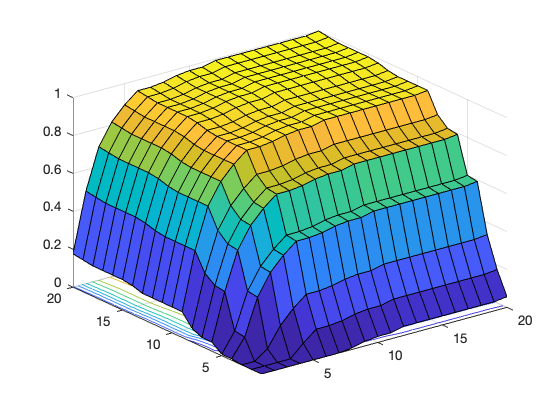

In [36]:
addpath('/Users/wlomsi/Documents/MATLAB/ecdfbiv');
joint_CDF=ecdfbiv([n_50, 100-x_500],20,20);
surfc([1:20],[1:20],joint_CDF);

*Interprete this CDF. Your answer goes here.*

Finally, we compare a function interpolating a sample distribution with the fitted parameterized PDF of that distribution computed earlier, cf. `distribution_fitting`. We look at $N_{50}$ and $X_{500}$ as two examples.

Therefore, we generate auxiliary functions `plotPDF` for plotting both functions, and two alternatives `samplePDF` and `parzanPDF` for interpolating the sample distribution. The former is simple to use and often good enough. The latter allows for fine tuning and is described in detail in the public notebook "Approximate PDFs with Parzen window density estimation".

In [37]:
%%file plotPDF.m
function plotPDF(xi, pd_fit, PDF)
    figure
    plot(xi, PDF(xi));
    hold on;
    plot(xi, pdf(pd_fit,xi));
end

Created file '/Users/wlomsi/Documents/ProjekteUni/Vorlesungen/ML 4DV660+4DV661+4DV652/Public ML Notebooks/plotPDF.m'.


In [38]:
%%file samplePDF.m
function PDF = samplePDF(sample, pd_fit, verbose)
    [f,xi] = ksdensity(sample);
    PDF = griddedInterpolant(xi,f);
    if (verbose)
        plotPDF(xi, pd_fit, PDF);
    end
end

Created file '/Users/wlomsi/Documents/ProjekteUni/Vorlesungen/ML 4DV660+4DV661+4DV652/Public ML Notebooks/samplePDF.m'.


In [39]:
%%file parzanPDF.m
function PDF = parzanPDF(sample, pd_fit, a, b, h, verbose)
    x = a:.1:b;
    mu = 0;
    sigma = 1;
    len_x = length(x);
    len_s = length(sample);
    f = zeros(1, len_x);
    for j=1:len_x
        xi=x(j);
        % Use a Gaussian Kernal function
        for i=1:len_s
            f(j) = f(j) + normpdf((xi-sample(i))/h,mu,sigma);
        end
        f(j) = f(j) /(len_s*h);
    end
    PDF = griddedInterpolant(x,f);
    if (verbose)
        plotPDF(x, pd_fit, PDF);
    end
end

Created file '/Users/wlomsi/Documents/ProjekteUni/Vorlesungen/ML 4DV660+4DV661+4DV652/Public ML Notebooks/parzanPDF.m'.


We fit the sample distribution $N_{50}$ in the range of $0\ldots 25$ with a tuning parameter $h=0.9$.

PDF_n_50 = 
  griddedInterpolant with properties:

            GridVectors: {[1x251 double]}
                 Values: [1x251 double]
                 Method: 'linear'
    ExtrapolationMethod: 'linear'



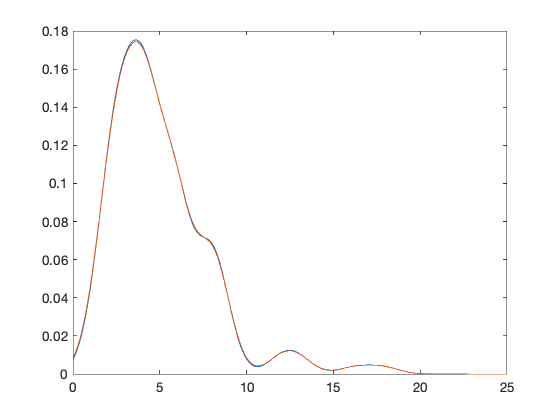

In [40]:
%PDF_n_50 = samplePDF(n_50,pd_n_50, true)
PDF_n_50 = parzanPDF(n_50, pd_n_50, 0, 25, 0.9, true)

We also fit the sample distribution $X_{500}$.

PDF_x_500 = 
  griddedInterpolant with properties:

            GridVectors: {[1x100 double]}
                 Values: [1x100 double]
                 Method: 'linear'
    ExtrapolationMethod: 'linear'



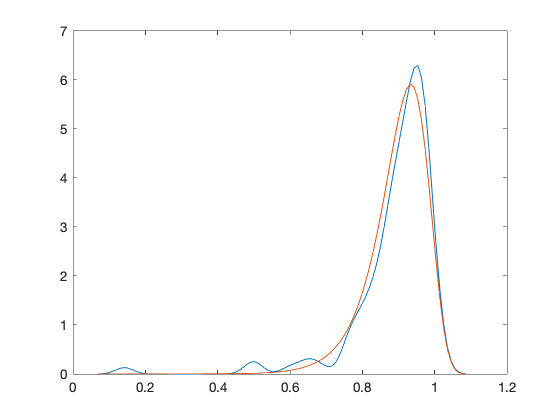

In [42]:
PDF_x_500 = samplePDF(x_500, pd_x_500, true)
%PDF_x_500 = parzanPDF(x_500, pd_x_500, 0, 2, 0.07, true)

## Self-entropy of an event and entropy of a distribution

We define a function that calculates the entropy of a sample distribution, based on a interploated parameterless  PDF approximation (calculated with `samplePDF` and `parzanPDF`, resp.) and the well-known parameterized ditribition (calculated with `distribution_fitting`). We also compute the Kullback-Leibler (KL) divergence in both directions.

For demonstration purpose, we implement numeric integration manually as auxiliary function. It comes in two variants: trapezoid and simpson's 3/8 rule.

In [46]:
%%file trapez.m
function I = trapez(f, a, b)
    N = (b-a)*100;
    x = linspace(a,b,N);
    dx = x(2)-x(1);
    for i=1:N
        z = f(x(i));
        y(i) = z;
    end
    w = [0.5 ones(1,N-2) 0.5];
    I = sum(w.*y)*dx;
end

Created file '/Users/wlomsi/Documents/ProjekteUni/Vorlesungen/ML 4DV660+4DV661+4DV652/Public ML Notebooks/trapez.m'.


In [47]:
%%file simpson.m
function I = simpson(f, a, b) %3/8 rule
    N = 3*(b-a)*100+1;
    x = linspace(a,b,N);
    dx = x(2)-x(1);
    I = 0;
    for i=1:3:N-3
        z0 = f(x(i));
        z1 = f(x(i+1));
        z2 = f(x(i+2));
        z3 = f(x(i+3));
        I = I+z0+3*z1+3*z2+z3;
    end
    I = I*(3*dx/8);
end

Created file '/Users/wlomsi/Documents/ProjekteUni/Vorlesungen/ML 4DV660+4DV661+4DV652/Public ML Notebooks/simpson.m'.


Auxiliary `if-then-else` as a function to implement the PDF, Entropy and KL divergence functions.

In [48]:
%%file ite.m
function res = ite(b,t,f)
    if b
        res=t;
    else
        res=f;
    end    
end

Created file '/Users/wlomsi/Documents/ProjekteUni/Vorlesungen/ML 4DV660+4DV661+4DV652/Public ML Notebooks/ite.m'.


In [49]:
a = -25; %you may start at negative values to integrate to 1 as the fitted PDF has probailities >0 for negative values
b = 25; %you may stop <100 to not numerically collect a lot of values coming from close to 0 probablities
f1 = @(x) ite(PDF_n_50(x)<=0, 0, PDF_n_50(x));
entropy1 = @(x) -1*ite(PDF_n_50(x)<=0, 0, PDF_n_50(x)*log(PDF_n_50(x)));

Integral1 = trapez(f1, a, b)
Entropy1 = trapez(entropy1, a, b)

Integral1 =
    0.9986
Entropy1 =
    2.3305



In [50]:
f2 = @(x) pdf(pd_n_50,x);
entropy2 = @(x) -1*pdf(pd_n_50,x)*log(pdf(pd_n_50,x));

Integral2 = trapez(f2, a, b)
Entropy2 = trapez(entropy2, a, b)

Integral2 =
    1.0000
Entropy2 =
    2.3455



In [51]:
divergence_1_2 = @(x) ite(PDF_n_50(x)<=0, ...
                        0, ...
                        PDF_n_50(x)*(log(PDF_n_50(x))-log(pdf(pd_n_50,x))));
Divergence_1_2 = trapez(divergence_1_2, a, b)
Divergence_1_2 = simpson(divergence_1_2, a, b)

Divergence_1_2 =
   4.1486e-06
Divergence_1_2 =
   4.5282e-06



In [52]:
eps = 1e-32;
divergence_2_1 = @(x) ite(PDF_n_50(x)<=0,...
                        pdf(pd_n_50,x)*(log(pdf(pd_n_50,x))-log(eps)),...
                        pdf(pd_n_50,x)*(log(pdf(pd_n_50,x))-log(PDF_n_50(x))));
Divergence_2_1 = trapez(divergence_2_1, a, b)
Divergence_2_1 = simpson(divergence_2_1, a, b)

Divergence_2_1 =
    0.0776
Divergence_2_1 =
    0.0774



*Why is the entropy of $N_{50}$ assuming it is proportional to the interpolated PDF different from the one assuming it is proportional to the fitted PDF? Why are the KL divergences different? Your answers go here.* 

## References

1. Amira Rachah and Delfim F. M. Torres: Mathematical Modelling, Simulation, and Optimal Control of the 2014 Ebola Outbreak in West Africa. Discrete Dynamics in Nature and Society, Volume 2015, Article ID 842792, https://www.hindawi.com/journals/ddns/2015/842792/.